In [1]:
import simpy
import math
import numpy as np
from functools import reduce
from tabulate import tabulate
import matplotlib.pyplot as plt
from queueing_system_simulation import QueuingSystemSimulation

Empirical Characteristics

In [2]:
# Calculate Empirical Characteristics
def calculate_empirical_characteristics(qs):
    L_queuing_system_list, L_queue_list, t_queuing_system_list, t_queue_list = qs.get_results()
    p = []
    for i in range(qs.n + qs.m + 1):
        request_frequency = reduce( lambda count, x: count+1 if x == i else count, L_queuing_system_list, 0)
        p.append(request_frequency / len(L_queuing_system_list))
    p_reject = p[qs.n + qs.m]
    Q = 1 - p_reject
    A = qs.lambd * Q
    n_occuped = Q * qs.lambd / qs.mu
    L_queue = sum(L_queue_list) / len(L_queue_list)
    L_queuing_system = sum(L_queuing_system_list) / len(L_queuing_system_list)
    t_queuing_system = sum(t_queuing_system_list) / len(t_queuing_system_list)
    t_queue = sum(t_queue_list) / len(t_queue_list)

    return p, Q, A, p_reject, n_occuped, L_queuing_system, L_queue, t_queuing_system, t_queue

Theoretical Characteristics

In [3]:
# Calculate Theoretical Characteristics
def calculate_theoretical_characteristics(n, m, lambd, mu, v):
    alpha = lambd / mu
    betta = v / mu 
    p=[]
    p_0 = (
                 sum([alpha ** i / math.factorial(i) for i in range (n+1)]) +
                 alpha ** n / math.factorial(n) *
                 sum([alpha ** i / reduce( 
                     lambda prod, x: prod * x, [ (n + l * betta) for l in range(1, i + 1) ] 
                 ) for i in range(1,m+1)])
           ) ** (-1)
    p.append(p_0)
    for k in range(1,n + 1):
        p_k = alpha ** k / math.factorial(k) * p[0]
        p.append(p_k)
    for i in range(1,m + 1):
        p_n_i = p[n] * alpha ** i / reduce( 
                     lambda prod, x: prod * x, [ (n + l * betta) for l in range(1,i + 1) ] 
                 )
        p.append(p_n_i)
    p_reject = p[n + m]
    Q = 1 - p_reject
    A = lambd * Q
    L_queue = sum([ i * p[n + i] for i in range(1,m + 1)])
    n_occuped = Q * lambd / mu
    L_queuing_system = sum([k * p[k] for k in range(1, n + 1)]) + sum([(n + i) * p[n + i] for i in range(1, m + 1)])
    t_queuing_system = L_queuing_system / lambd
    t_queue = L_queue / lambd

    return p, Q, A, p_reject, n_occuped, L_queuing_system, L_queue, t_queuing_system, t_queue

In [4]:
def display_characteristics(theoretical_characteristics, empirical_characteristics):
    p1, Q1, A1, p_reject1, n_occuped1, L_queuing_system1, L_queue1, t_queuing_system1, t_queue1 = theoretical_characteristics
    p2, Q2, A2, p_reject2, n_occuped2, L_queuing_system2, L_queue2, t_queuing_system2, t_queue2 = empirical_characteristics

    output_list = [[f'p{(i)}', p1[i], p2[i]] for i in range (min(len(p1), 15))]
    output_list.extend([['Q (относительная пропускная способность)', Q1, Q2],
                        ['A (абсолютная пропускная способность)', A1, A2],
                        ['p отказа', p_reject1, p_reject2],
                        ['L СМО (среднее число заявок в СМО)', L_queuing_system1, L_queuing_system2],
                        ['L очереди (среднее число заявок в очереди)', L_queue1, L_queue2],
                        ['t СМО (среднее время заявки в СМО)', t_queuing_system1, t_queuing_system2],
                        ['t очереди (среднее время заявки в очереди)', t_queue1, t_queue2],
                        ['n занятости (среднее число занятых каналов)', n_occuped1, n_occuped2]])
    print(tabulate(output_list,
          headers=['', 'Теоретические характеристики', 'Эмпирические характеристики']))
    print()

In [5]:
def plot_graphs(theoretical_characteristic, empirical_characteristic):
    plt.plot(theoretical_characteristic[0])
    plt.plot(empirical_characteristic[0])
    plt.legend(['Теоретические вероятности', 'Эмпирические вероятности'])
    plt.xlabel('p[i]')
    plt.show()

def get_xi_2(o, e):
    return sum(((o[i] - e[i]) ** 2) / e[i] for i in range(len(o)))

Tests

In [6]:
def simulate(n, m, lambd, mu, v, test_time=10000):
    qs = QueuingSystemSimulation.simulate_queuing_system(n, m, lambd, mu, v, test_time)
    empirical_characteristics = calculate_empirical_characteristics(qs)
    theoretical_characteristics = calculate_theoretical_characteristics(n, m, lambd, mu, v)
    return theoretical_characteristics, empirical_characteristics

def test_analyse(n, m, lambd, mu, v, test_time=10000):
    theoretical_characteristics, empirical_characteristics = simulate(n, m, lambd, mu, v, test_time)

    print(f'Характеристики СМО: n={n}, m={m}, lambda={lambd}, mu={mu}, v={v}')
    display_characteristics(theoretical_characteristics, empirical_characteristics)

    t_estimation_list = theoretical_characteristics[0] + [
        theoretical_characteristics[i] for i in range(1, len(theoretical_characteristics))
    ]
    e_estimation_list = empirical_characteristics[0] + [
        empirical_characteristics[i] for i in range(1, len(empirical_characteristics))
    ]
    xi_2_estimation = get_xi_2(e_estimation_list, t_estimation_list)
    print('Xi-квадрат:', xi_2_estimation)

    plot_graphs(theoretical_characteristics, empirical_characteristics)

Характеристики СМО: n=3, m=3, lambda=2, mu=1, v=1
                                               Теоретические характеристики    Эмпирические характеристики
-------------------------------------------  ------------------------------  -----------------------------
p0                                                                0.135952                       0.134004
p1                                                                0.271903                       0.272363
p2                                                                0.271903                       0.274416
p3                                                                0.181269                       0.181659
p4                                                                0.0906344                      0.090454
p5                                                                0.0362538                      0.0343895
p6                                                                0.0120846                      0.

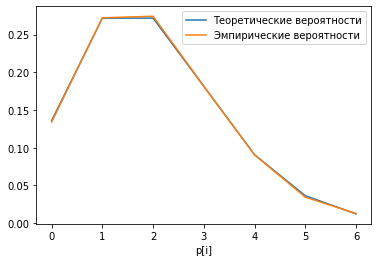

In [7]:
test_analyse(n = 3, m = 3, lambd = 2, mu = 1, v = 1)

Характеристики СМО: n=3, m=2, lambda=5, mu=1, v=2
                                               Теоретические характеристики    Эмпирические характеристики
-------------------------------------------  ------------------------------  -----------------------------
p0                                                                0.0133249                      0.01152
p1                                                                0.0666244                      0.0629337
p2                                                                0.166561                       0.164433
p3                                                                0.277602                       0.278542
p4                                                                0.277602                       0.281497
p5                                                                0.198287                       0.201075
Q (относительная пропускная способность)                          0.801713                       0.7

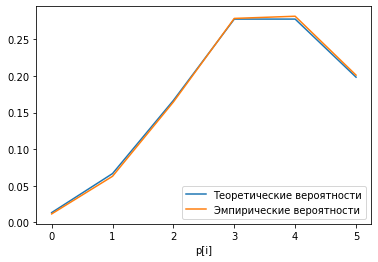

In [8]:
test_analyse(n = 3, m = 2, lambd = 5, mu = 1, v = 2)

Характеристики СМО: n=8, m=6, lambda=18, mu=4, v=3
                                               Теоретические характеристики    Эмпирические характеристики
-------------------------------------------  ------------------------------  -----------------------------
p0                                                              0.011077                       0.011687
p1                                                              0.0498463                      0.0505303
p2                                                              0.112154                       0.113193
p3                                                              0.168231                       0.169222
p4                                                              0.18926                        0.188228
p5                                                              0.170334                       0.170809
p6                                                              0.127751                       0.125716
p7    

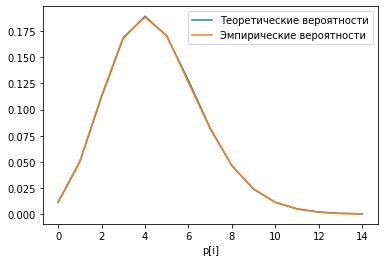

In [9]:
test_analyse(n = 8, m = 6, lambd = 18, mu = 4, v = 3)

Характеристики СМО: n=2, m=30, lambda=50, mu=3, v=2
                                               Теоретические характеристики    Эмпирические характеристики
-------------------------------------------  ------------------------------  -----------------------------
p0                                                              2.74041e-10                    1.99712e-06
p1                                                              4.56735e-09                    1.99712e-06
p2                                                              3.80612e-08                    1.99712e-06
p3                                                              2.37883e-07                    1.99712e-06
p4                                                              1.18941e-06                    1.99712e-06
p5                                                              4.95589e-06                    5.99135e-06
p6                                                              1.76996e-05                 

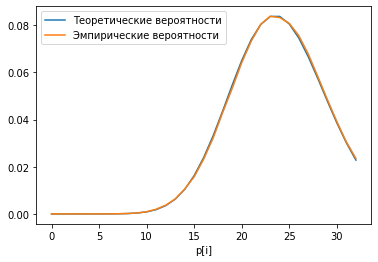

In [10]:
test_analyse(n = 2, m = 30, lambd = 50, mu = 3, v = 2)

Graphs, that prove QSS stable state

In [11]:
def plot_stabilization_process(n, m, lambd, mu, v, test_time_max=10000, count_measurements=100):
    times = [i * count_measurements for i in range(1, int(test_time_max / count_measurements + 1))]
    p_count = n + m + 1
    p_list = [[] for _ in range(p_count)]
    p_theoretical = []
    for time in times:
        theoretical_characteristics, empirical_characteristics = simulate(n, m, lambd, mu, v, time)
        for i in range(p_count):
            p_list[i].append(empirical_characteristics[0][i])
        if len(p_theoretical) == 0:
            p_theoretical = theoretical_characteristics[0]

    fig, axes_list = plt.subplots(ncols=1, nrows=p_count, figsize=(12, 18),
                                    gridspec_kw={'height_ratios': [1 for _ in range(p_count)], 'width_ratios': [1]})

    for i in range(p_count):
        axes_list[i].set_title(f'p{i}')
        axes_list[i].plot(times, [p_theoretical[i]]*len(times), '-k')
        axes_list[i].fill_between(times, y1=p_list[i], color=(np.random.random(), np.random.random(), np.random.random()), step='post', alpha=0.5)
    fig.tight_layout()

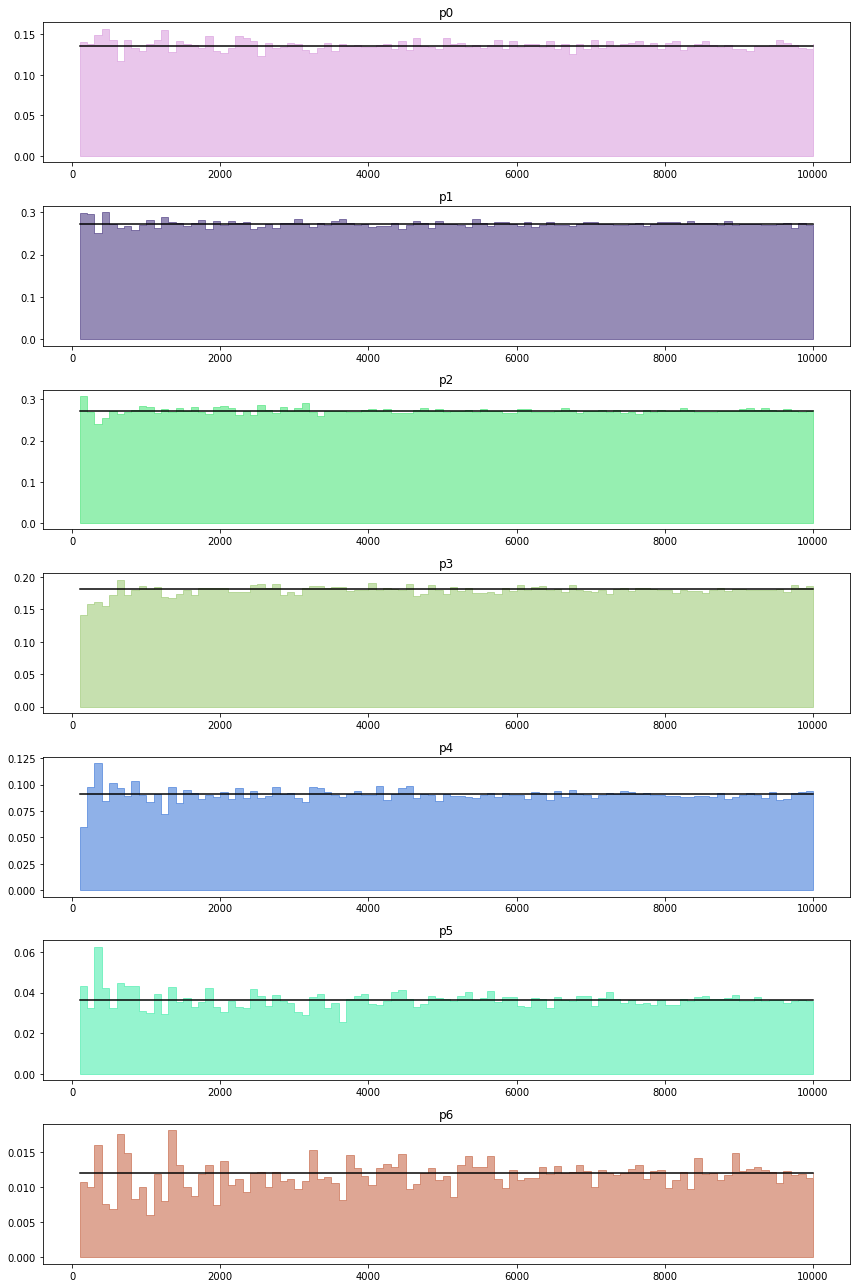

In [12]:
plot_stabilization_process(n = 3, m = 3, lambd = 2, mu = 1, v = 1)